In [16]:
import netCDF4, numpy as np, cf_units, cftime
import matplotlib.pyplot as plt
import xarray as xr
import aera
import seriestools, tools
from scipy.signal import butter, filtfilt
from notebook_metadata import create_savefig

savefig = create_savefig(dir='/g/data/p66/mrd599/temp', nb='luc_emissions.ipynb')
%matplotlib inline

In [2]:
areacella = xr.load_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/fx/areacella/gn/latest/areacella_fx_ACCESS-ESM1-5_piControl_r1i1p1f1_gn.nc').areacella
sftlf = xr.load_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/fx/sftlf/gn/latest/sftlf_fx_ACCESS-ESM1-5_piControl_r1i1p1f1_gn.nc').sftlf

In [3]:
# Use NBP from runs including LUC
# NBP and NEP are the same in no LUC runs
# All annual means calculated with cdo yearmonmean
nbp_hist = xr.open_dataset('/g/data/p66/mrd599/AERA/nbp_hist_ann.nc').nbp
nbp_126 = xr.open_dataset('/g/data/p66/mrd599/AERA/nbp_ssp126_ann.nc').nbp
nbp_585 = xr.open_dataset('/g/data/p66/mrd599/AERA/nbp_ssp585_ann.nc').nbp
d = xr.open_dataset('/g/data/p66/mrd599/AERA/nbp_HI-noluc-05.nc')
nbp_hist_nl = d.fld_s03i262 - d.fld_s03i293
d = xr.open_dataset('/g/data/p66/mrd599/AERA/nbp_SSP-126-nl-05.nc')
nbp_126_nl = d.fld_s03i262 - d.fld_s03i293

sf = 86400 * 365 * 1e-12  # kg/s to Pg/year
nbp_hist_g = (nbp_hist*areacella).sum(('lat', 'lon')) * sf
nbp_126_g = (nbp_126*areacella).sum(('lat', 'lon')) * sf
nbp_585_g = (nbp_585*areacella).sum(('lat', 'lon')) * sf
nbp_hist_nl_g = (nbp_hist_nl*areacella).sum(('lat', 'lon')) * sf
nbp_126_nl_g = (nbp_126_nl*areacella).sum(('lat', 'lon')) * sf

# flux_lu_hist = iris.load_cube('/scratch/p66/mrd599/esm/HI-05_co2flux.nc', 'fld_s03i100')
# flux_nl_hist = iris.load_cube('/scratch/p66/mrd599/esm/HI-noluc-05_co2flux.nc', 'fld_s03i100')
# flux_lu_126 = iris.load_cube('/scratch/p66/txz599/tmp/cfluxes_SSP_126_05_ymonmean.nc', 'fld_s03i100')
# flux_nl_126 = iris.load_cube('/scratch/p66/txz599/tmp/cfluxes_SSP_126_nl_05_ymonmean.nc', 'fld_s03i100')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array

In [4]:
nbp = xr.concat([nbp_hist_g, nbp_126_g], 'time')
nbp_nl = xr.concat([nbp_hist_nl_g, nbp_126_nl_g], 'time')
luc = nbp_nl - nbp[:251]

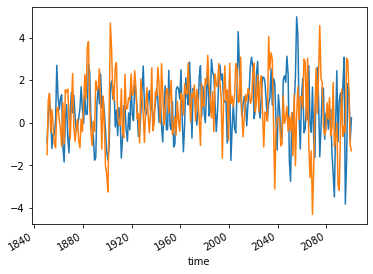

In [5]:
nbp[:251].plot()
nbp_nl.plot()

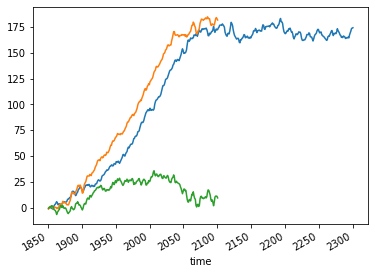

In [6]:
nbp.cumsum().plot()
nbp_nl.cumsum().plot()
luc.cumsum().plot()

In [7]:
print('HIST', nbp_hist_g.sum().values)
print('HIST NL', nbp_hist_nl_g.sum().values)
print('SSP1-2.6', nbp_126_g[:86].sum().values)
print('SSP1-2.6 NL', nbp_126_nl_g.sum().values)

HIST 107.265205
HIST NL 138.67975
SSP1-2.6 65.100655
SSP1-2.6 NL 42.993607


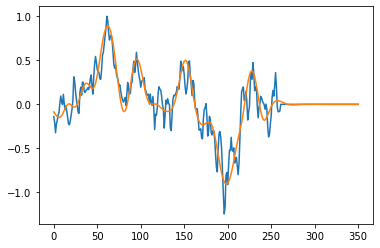

In [17]:
# AERA specifies using a 21 year running mean
pad = 100
tmp = np.concatenate([[0]*pad, luc.data, [0]*pad])
# plt.plot(tmp)
luc_mean = np.convolve(tmp, np.ones(21), 'same')[pad:] / 21.
plt.plot(luc_mean)

order = 3
Wn = 0.033 # Cut off # in Hz
btype = 'lowpass'
fs = 1  # Sampling freq in Hz
b, a = butter(order, Wn, btype, fs = fs)
luc_b = filtfilt(b, a, tmp)[pad:]
plt.plot(luc_b)

(1850.0, 2150.0)

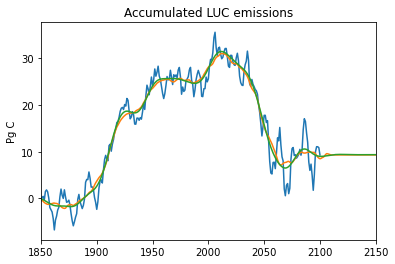

In [18]:
fiug, axes = plt.subplots()
plt.plot(np.arange(1850,2101), luc.data.cumsum())
plt.plot(np.arange(1850, 1850+len(luc_mean)), luc_mean.cumsum())
plt.plot(np.arange(1850, 1850+len(luc_b)), luc_b.cumsum())
axes.set_title('Accumulated LUC emissions')
axes.set_ylabel('Pg C')
axes.set_xlim(1850,2150)

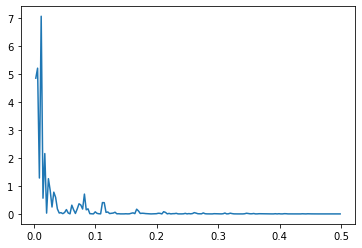

In [ ]:
f, p = tools.powerspec(luc.data, fs=1, smooth=1)
f2, p2 = tools.powerspec(luc_mean, fs=1, smooth=1)
fig, axes = plt.subplots()
# plt.plot(f,p)
plt.plot(f2,p2)

In [20]:
df = aera.get_base_df()
# print(df)

Use the following non-CO2 RF file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/nonco2_rf_ssp126_v1.dat
Use the following non-CO2 emission file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/nonco2_emis_ssp126_v3.dat
Use the following land use emission file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/lu_emis_ssp126_bern3d_adj_GCB2020_v1.dat
Use the following historical fossil fuel CO2 emission file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/co2_ff_GCP_plus_NDC_v1.dat
Use the following historical N2O concentration file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/n2o_conc_ssp126_v1.dat


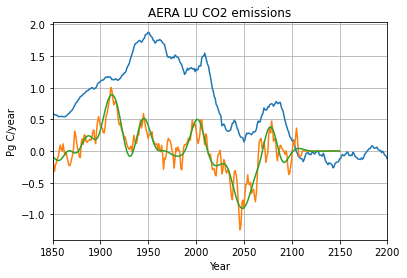

In [23]:
fig, axes = plt.subplots()
# df['ff_emission'].plot()
df['lu_emission'].plot()
plt.plot(np.arange(1850,2151), luc_mean[:301])
plt.plot(np.arange(1850,2151), luc_b[:301])
axes.set_title('AERA LU CO2 emissions')
axes.set_ylabel('Pg C/year')
axes.set_xlabel('Year')
axes.set_xlim(1850,2200)
# axes.set_ylim(0,2)
axes.grid(True)
savefig('lu_aera.png')

In [24]:
d = netCDF4.Dataset('/g/data/p66/mrd599/AERA/luc_emissions.nc', 'w')
d.createDimension('time', None)
d.createDimension('nv', 2)
d.createVariable('time', np.float32, ('time',))
d.createVariable('luc', np.float32, ('time',))

time = d.variables['time']
time.units = 'days since 1850-01-01 00:00'
time.calendar = 'proleptic_gregorian'

luc_var = d.variables['luc']
luc_var.units = 'Pg C year-1'
# luc_var.long_name = 'Carbon emission due to LUC smoothed with 21 year running mean'
luc_var.long_name = 'Carbon emission due to LUC smoothed with Butterworth filter with 30 year cutoff'

time_units = cf_units.Unit("days since 1850-01-01 00:00", calendar='proleptic_gregorian')

t = 0
for year in range(1850,2151):
    date0 = cftime.DatetimeProlepticGregorian(year, 1, 1, 0, 0, 0)
    date1 = cftime.DatetimeProlepticGregorian(year+1, 1, 1, 0, 0, 0)
    tb0 = time_units.date2num(date0)
    tb1 = time_units.date2num(date1)
    time[t] = (tb0+tb1)*0.5
    t += 1
luc_var[:] = luc_b[:301]

d.close()


In [83]:
d = netCDF4.Dataset('/g/data/p66/mrd599/AERA/luc_raw.nc', 'w')
d.createDimension('time', None)
d.createDimension('nv', 2)
d.createVariable('time', np.float32, ('time',))
d.createVariable('luc', np.float32, ('time',))

time = d.variables['time']
time.units = 'days since 1850-01-01 00:00'
time.calendar = 'proleptic_gregorian'

luc_var = d.variables['luc']
luc_var.units = 'Pg C year-1'
luc_var.long_name = 'Carbon emission due to LUC smoothed with 21 year running mean'

time_units = cf_units.Unit("days since 1850-01-01 00:00", calendar='proleptic_gregorian')

t = 0
for year in range(1850,2101):
    date0 = cftime.DatetimeProlepticGregorian(year, 1, 1, 0, 0, 0)
    date1 = cftime.DatetimeProlepticGregorian(year+1, 1, 1, 0, 0, 0)
    tb0 = time_units.date2num(date0)
    tb1 = time_units.date2num(date1)
    time[t] = (tb0+tb1)*0.5
    t += 1
luc_var[:] = luc[:]

d.close()
